# UTS Deep Learning — Klasifikasi Angka MNIST

#### Nama : Helen Kezia Nofitri Siahaan

#### NIM: 202332035

### 1. Imports Kode

In [1]:
import os, math, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.13.0


### 2. Load dan PraPemrosesan MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Normalisasi ke [0,1] + tambahkan channel (N,28,28,1)
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]
x_test  = (x_test.astype("float32")  / 255.0)[..., np.newaxis]

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

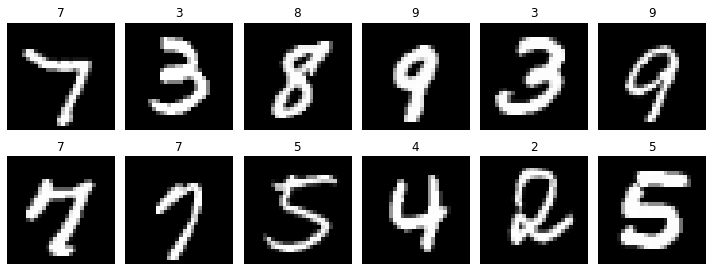

In [5]:
#  Visualisasi beberapa contoh
idxs = np.random.choice(len(x_train), 12, replace=False)
ncols = 6
nrows = math.ceil(len(idxs)/ncols)

plt.figure(figsize=(10,4))
for i, idx in enumerate(idxs):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(x_train[idx].squeeze(), cmap="gray")
    plt.title(int(np.argmax(y_train_cat[idx])))
    plt.axis("off")
plt.tight_layout()
plt.show()

#### a. Model A - CNN dari Nol ( 0 )

In [6]:
def build_model_a(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation="relu"),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_a = build_model_a()
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0

Epoch 1/5
422/422 [==============================] - 27s 60ms/step - loss: 0.2485 - accuracy: 0.9246 - val_loss: 0.0503 - val_accuracy: 0.9853
Epoch 2/5
422/422 [==============================] - 23s 54ms/step - loss: 0.0668 - accuracy: 0.9794 - val_loss: 0.0389 - val_accuracy: 0.9885
Epoch 3/5
422/422 [==============================] - 23s 54ms/step - loss: 0.0462 - accuracy: 0.9861 - val_loss: 0.0338 - val_accuracy: 0.9892
Epoch 4/5
422/422 [==============================] - 23s 55ms/step - loss: 0.0372 - accuracy: 0.9888 - val_loss: 0.0326 - val_accuracy: 0.9907
Epoch 5/5
422/422 [==============================] - 23s 54ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0331 - val_accuracy: 0.9902


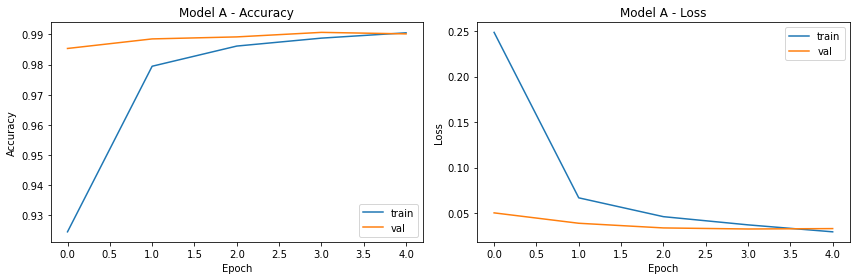

Model A - Test Accuracy: 0.9913


In [7]:
# Train Model A
EPOCHS_A = 5
BATCH_A = 128

history_a = model_a.fit(
    x_train, y_train_cat,
    validation_split=0.1,
    epochs=EPOCHS_A,
    batch_size=BATCH_A,
    verbose=1
)

# Plot history
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(history_a.history["accuracy"], label="train")
ax[0].plot(history_a.history["val_accuracy"], label="val")
ax[0].set_title("Model A - Accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Accuracy"); ax[0].legend()

ax[1].plot(history_a.history["loss"], label="train")
ax[1].plot(history_a.history["val_loss"], label="val")
ax[1].set_title("Model A - Loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss"); ax[1].legend()

plt.tight_layout(); plt.show()

test_loss_a, test_acc_a = model_a.evaluate(x_test, y_test_cat, verbose=0)
print(f"Model A - Test Accuracy: {test_acc_a:.4f}")

In [8]:
#Evaluasi Model A pada 30 Citra Tulisan Tangan 

from pathlib import Path
from PIL import Image

DIGITS = [0, 3, 5]
SEARCH_DIR = Path(".").resolve()   
EXTS = ("png","jpg","jpeg","bmp","webp")

print("Working dir:", SEARCH_DIR)

def rglob_first(base: Path, pattern_stem: str):
    """Cari file pertama yang cocok untuk beberapa ekstensi."""
    for ext in EXTS:
        matches = list(base.rglob(f"{pattern_stem}.{ext}"))
        if matches:
            # pilih file pertama (stabil dengan sort path)
            return str(sorted(matches)[0])
    return None

def find_custom_files(base: Path, digits=(0,3,5)):
    found = []
    missing = []
    for d in digits:
        for i in range(1, 11):
            stem = f"{i}_{d}_proc"
            p = rglob_first(base, stem)
            if p:
                found.append((stem, p))
            else:
                missing.append(stem)
    # urutkan: berdasarkan digit lalu index (1..10)
    def _key(item):
        st = item[0]                   # e.g. "7_3_proc"
        idx = int(st.split("_")[0])    # 7
        dig = int(st.split("_")[1])    # 3
        return (dig, idx)
    found = sorted(found, key=_key)

    if missing:
        print(f"[INFO] {len(missing)} file belum ditemukan (akan dilewati):")
        print(", ".join(missing))
    print(f"[INFO] Ditemukan {len(found)} file.")
    return found

custom_records = find_custom_files(SEARCH_DIR, DIGITS)

def load_custom_28x28_gray(path: str):
    """File sudah grayscale 28x28 → normalisasi [0,1] + tambah channel."""
    img = Image.open(path).convert("L")
    if img.size != (28,28):  # jaga-jaga
        img = img.resize((28,28), Image.BILINEAR)
    arr = np.array(img).astype("float32") / 255.0
    arr = arr[..., np.newaxis]  # (28,28,1)
    return arr

Working dir: C:\Users\kezia\Downloads\UTS_DEEPL_A_202332035_HELEN_KEZIA_NOFITRI_SIAHAAN
[INFO] Ditemukan 30 file.


Custom images loaded: (30, 28, 28, 1)


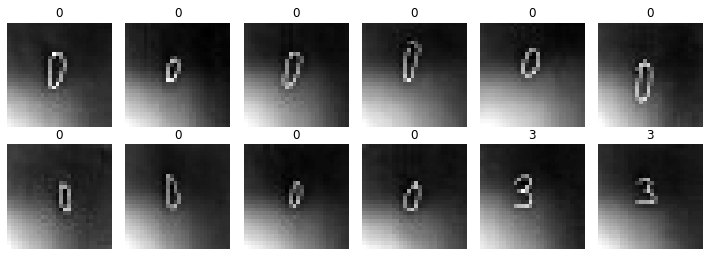

In [9]:
#Bangun array
x_custom, y_custom, paths = [], [], []
for stem, path in custom_records:
    label = int(stem.split("_")[1])   
    x_custom.append(load_custom_28x28_gray(path))
    y_custom.append(label)
    paths.append(path)

if x_custom:
    x_custom = np.stack(x_custom)
else:
    x_custom = np.zeros((0,28,28,1), dtype="float32")
y_custom = np.array(y_custom, dtype="int64")

print("Custom images loaded:", x_custom.shape)

#Visualisasi
n_show = min(12, len(x_custom))
if n_show > 0:
    cols = 6
    rows = int(np.ceil(n_show/cols))
    plt.figure(figsize=(10, 1.8*rows))
    for i in range(n_show):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_custom[i].squeeze(), cmap="gray")
        plt.title(str(y_custom[i]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [10]:
#Prediksi & akurasi Model A
if len(x_custom) > 0:
    probs_a = model_a.predict(x_custom, verbose=0)
    preds_a = probs_a.argmax(axis=1)
    acc_a_custom = (preds_a == y_custom).mean()
    print(f"Model A - Akurasi pada {len(x_custom)} citra tulisan tangan: {acc_a_custom:.4f}")
else:
    preds_a = np.array([], dtype=int)
    acc_a_custom = 0.0
    print("[WARN] Tidak ada file yang dievaluasi.")

Model A - Akurasi pada 30 citra tulisan tangan: 0.0000


In [11]:
#Simpan hasil Model A
results_a = pd.DataFrame({
    "file_path": paths,
    "true_label": y_custom,
    "pred_label_model_a": preds_a
})
csv_a_path = "predictions_model_a_202332035.csv"
results_a.to_csv(csv_a_path, index=False)
print("Saved:", csv_a_path)

# Ringkasan kontingensi
if len(results_a) > 0:
    print("\nTabulasi (true vs pred):")
    print(results_a.groupby(["true_label","pred_label_model_a"]).size())

Saved: predictions_model_a_202332035.csv

Tabulasi (true vs pred):
true_label  pred_label_model_a
0           1                     10
3           1                      8
            6                      2
5           1                     10
dtype: int64


#### b. Model B - Transfer Learning

In [12]:
IMG_SIZE = 96

def to_rgb3_and_resize(x):
    # x: (N,28,28,1) in [0,1]
    x3 = np.repeat(x, 3, axis=-1)  # grayscale → 3 channel
    x_resized = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3), dtype="float32")
    for i in range(x.shape[0]):
        x_resized[i] = tf.image.resize(x3[i], (IMG_SIZE, IMG_SIZE), method="bilinear").numpy()
    return x_resized

x_train_tl = to_rgb3_and_resize(x_train)
x_test_tl  = to_rgb3_and_resize(x_test)

base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
z = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
z = base(z, training=False)
z = layers.GlobalAveragePooling2D()(z)
z = layers.Dropout(0.2)(z)
outputs = layers.Dense(num_classes, activation="softmax")(z)
model_b = models.Model(inputs, outputs)

model_b.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_b.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 96, 96, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 96, 96, 3)         0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

Epoch 1/5
422/422 [==============================] - 240s 559ms/step - loss: 2.3469 - accuracy: 0.1305 - val_loss: 2.2044 - val_accuracy: 0.2943
Epoch 2/5
422/422 [==============================] - 221s 523ms/step - loss: 2.1965 - accuracy: 0.2013 - val_loss: 2.1150 - val_accuracy: 0.4897
Epoch 3/5
422/422 [==============================] - 214s 508ms/step - loss: 2.1151 - accuracy: 0.2567 - val_loss: 2.0264 - val_accuracy: 0.6077
Epoch 4/5
422/422 [==============================] - 210s 498ms/step - loss: 2.0542 - accuracy: 0.2927 - val_loss: 1.9749 - val_accuracy: 0.4890
Epoch 5/5
422/422 [==============================] - 219s 519ms/step - loss: 2.0036 - accuracy: 0.3203 - val_loss: 1.9283 - val_accuracy: 0.6145


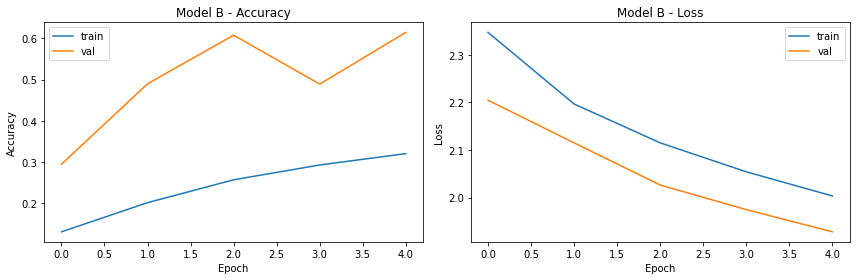

Model B - Test Accuracy: 0.6068


In [13]:
#Train Model B
EPOCHS_B = 5
BATCH_B = 128

history_b = model_b.fit(
    x_train_tl, y_train_cat,
    validation_split=0.1,
    epochs=EPOCHS_B,
    batch_size=BATCH_B,
    verbose=1
)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(history_b.history["accuracy"], label="train")
ax[0].plot(history_b.history["val_accuracy"], label="val")
ax[0].set_title("Model B - Accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Accuracy"); ax[0].legend()

ax[1].plot(history_b.history["loss"], label="train")
ax[1].plot(history_b.history["val_loss"], label="val")
ax[1].set_title("Model B - Loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss"); ax[1].legend()

plt.tight_layout(); plt.show()

test_loss_b, test_acc_b = model_b.evaluate(x_test_tl, y_test_cat, verbose=0)
print(f"Model B - Test Accuracy: {test_acc_b:.4f}")

In [14]:
#Evaluasi Model B pada 30 Citra Tulisan Tangan

def to_rgb3_and_resize_single(arr_28x28x1):
    x3 = np.repeat(arr_28x28x1, 3, axis=-1)                        # (28,28,3)
    return tf.image.resize(x3, (IMG_SIZE, IMG_SIZE), method="bilinear").numpy()

if len(x_custom) > 0:
    x_custom_b = np.stack([to_rgb3_and_resize_single(x_custom[i]) for i in range(len(x_custom))]).astype("float32")
    xb = tf.keras.applications.mobilenet_v2.preprocess_input(x_custom_b.copy())
    probs_b = model_b.predict(xb, verbose=0)
    preds_b = probs_b.argmax(axis=1)
    acc_b_custom = (preds_b == y_custom).mean()
    print(f"Model B - Akurasi pada 30 citra tulisan tangan: {acc_b_custom:.4f}")
else:
    preds_b = np.array([]); acc_b_custom = 0.0

# Simpan & bandingkan
results_b = pd.DataFrame({
    "file_path": paths,
    "true_label": y_custom,
    "pred_label_model_b": preds_b
})

merged = results_a.merge(results_b.drop(columns=["true_label"]), on="file_path", how="outer")
merged["correct_model_a"] = (merged["true_label"] == merged["pred_label_model_a"])
merged["correct_model_b"] = (merged["true_label"] == merged["pred_label_model_b"])

csv_b_path = "predictions_model_b_202332035.csv"
merged.to_csv(csv_b_path, index=False)
print("Saved:", csv_b_path)

print("\nRingkasan Perbandingan (5 baris pertama):")
display_cols = ["file_path","true_label","pred_label_model_a","pred_label_model_b","correct_model_a","correct_model_b"]
merged[display_cols].head()

Model B - Akurasi pada 30 citra tulisan tangan: 0.0000
Saved: predictions_model_b_202332035.csv

Ringkasan Perbandingan (5 baris pertama):


,file_path,true_label,pred_label_model_a,pred_label_model_b,correct_model_a,correct_model_b
0,C:\Users\kezia\Downloads\UTS_DEEPL_A_202332035...,0,1,1,False,False
1,C:\Users\kezia\Downloads\UTS_DEEPL_A_202332035...,0,1,1,False,False
2,C:\Users\kezia\Downloads\UTS_DEEPL_A_202332035...,0,1,1,False,False
3,C:\Users\kezia\Downloads\UTS_DEEPL_A_202332035...,0,1,1,False,False
4,C:\Users\kezia\Downloads\UTS_DEEPL_A_202332035...,0,1,1,False,False


In [15]:
#Analisis Perbandingan & Kesimpulan (ringkas otomatis)
print("== Ringkasan Akurasi ==")
print(f"Model A - Test Accuracy (MNIST): {test_acc_a:.4f}")
print(f"Model B - Test Accuracy (MNIST resized->MobileNetV2): {test_acc_b:.4f}")
print(f"Model A - Akurasi pada 30 citra tulisan tangan: {acc_a_custom:.4f}")
print(f"Model B - Akurasi pada 30 citra tulisan tangan: {acc_b_custom:.4f}")

note = []
if acc_b_custom > acc_a_custom:
    note.append("Pada tulisan tangan sendiri, Model B (Transfer Learning) unggul dibanding Model A.")
elif acc_b_custom < acc_a_custom:
    note.append("Pada tulisan tangan sendiri, Model A (CNN dari nol) unggul dibanding Model B.")
else:
    note.append("Pada tulisan tangan sendiri, kedua model memiliki akurasi yang sama.")
note.append("Perbedaan bisa dipengaruhi domain shift (gaya tulisan vs MNIST) serta pipeline resize 1→3 channel untuk Model B.")
print("\n".join(note))

== Ringkasan Akurasi ==
Model A - Test Accuracy (MNIST): 0.9913
Model B - Test Accuracy (MNIST resized->MobileNetV2): 0.6068
Model A - Akurasi pada 30 citra tulisan tangan: 0.0000
Model B - Akurasi pada 30 citra tulisan tangan: 0.0000
Pada tulisan tangan sendiri, kedua model memiliki akurasi yang sama.
Perbedaan bisa dipengaruhi domain shift (gaya tulisan vs MNIST) serta pipeline resize 1→3 channel untuk Model B.
